### Basic Introduction to Machine Learning: 03-flux-ring2  
Jeff Fessler, University of Michigan  
2018-10-18 Julia 1.0.1 version

### Illustrate basic artificial NN training using Julia's Flux library
This is a Jupyter notebook based on the Julia language  
[https://julialang.org/]  
To run it you will need Julia 1.0.1 or later and to install several packages.  
For some tutorials on using Julia see:  
[http://web.eecs.umich.edu/~fessler/course/551/julia/tutor/]

In [1]:
# packages used
using LinearAlgebra
using Random
using LaTeXStrings # pretty plot labels
using Plots
using Flux # Julia package for deep learning
using Flux: throttle, mse
if true
    pyplot()
    pyplot(markersize=7, markerstrokecolor=:auto)
    fnt = font("DejaVu Sans", 15) # larger default font
    pyplot(guidefont=fnt, xtickfont=fnt, ytickfont=fnt, legendfont=fnt)
end

Plots.PyPlotBackend()

In [2]:
# function to simulate data that cannot be linearly separated
function simdata(; n1 = 40, n2 = 120, σ1 = 0.8, σ2 = 2, r2 = 3)
    data1 = σ1 * randn(2,n1)
    rad2 = r2 .+ σ2*rand(1,n2)
    ang2 = rand(1,n2) * 2π
    data2 = [rad2 .* cos.(ang2); rad2 .* sin.(ang2)]
    X = [data1 data2] # 2 × N = n1+n2
    Y = [-ones(1,n1) ones(1,n2)] # 1 × N
    @assert size(X,2) == size(Y,2)
    return (X,Y)
end;

In [3]:
# scatter plot routine
function datasplit(X,Y)
    i1 = Y[:] .== -1
    i2 = Y[:] .== 1
    data1 = X[:,i1]
    data2 = X[:,i2]
    return (data1, data2)
end

function plot_data(X,Y)
    data1,data2 = datasplit(X,Y)
    plot(xlabel=L"x_1", ylabel=L"x_2")
    scatter!(data1[1,:], data1[2,:], color=[:blue], label="class1")
    scatter!(data2[1,:], data2[2,:], color=[:red], label="class2")
    plot!(xlim=[-1,1]*6, ylim=[-1,1]*6)
    plot!(aspect_ratio=1, xtick=-6:6:6, ytick=-6:6:6)
end;

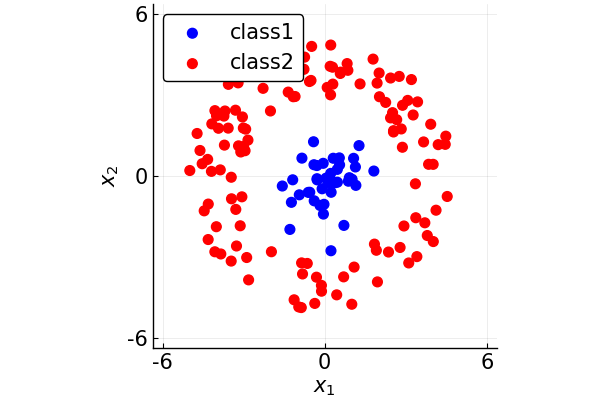

In [4]:
# Training data
Random.seed!(0)
(Xtrain, Ytrain) = simdata()

plot_data(Xtrain,Ytrain)
#savefig("ml-flux-data.pdf")

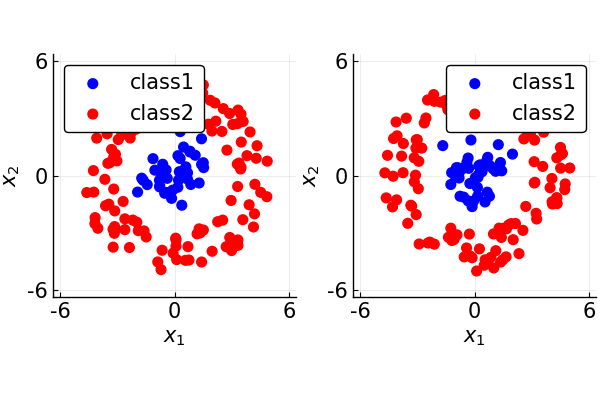

In [5]:
# validation and testing data
(Xvalid, Yvalid) = simdata()
(Xtest, Ytest) = simdata()

p1 = plot_data(Xvalid, Yvalid)
p2 = plot_data(Xtest, Ytest)
plot(p1, p2)

In [6]:
# train a basic NN model with 1 hidden layer
nhidden = 10 # neurons in hidden layer
model = Chain(Dense(2,nhidden,relu), Dense(nhidden,1))
loss(x, y) = mse(model(x), y)
iters = 10000
dataset = Base.Iterators.repeated((Xtrain, Ytrain), iters)
Flux.train!(loss, dataset, ADAM(params(model)))

In [7]:
function display_decision_boundaries(X, Y, model;
            x1range=LinRange(-1,1,101)*6, x2range=x1range, τ=0.0)
    data1,data2 = datasplit(X,Y)
    D = [model([x1;x2])[1].data for x2 = x2range, x1 = x1range]
    heatmap(x1range, x2range, sign.(D.-τ), color=:grays) 
    scatter!(data1[1,:], data1[2,:], color = [:blue], label = "Class 1")
    scatter!(data2[1,:], data2[2,:], color = [:red], label = "Class 2")
    plot!(xlabel=L"x_1", ylabel=L"x_2")
    plot!(xlim=[-1,1]*6, ylim=[-1,1]*6)
    plot!(aspect_ratio=1, xtick=-6:6:6, ytick=-6:6:6)
end

display_decision_boundaries (generic function with 1 method)

In [8]:
@show lossXY = loss(Xtrain,Ytrain).data
display_decision_boundaries(X, Y, model)
#plot!(title = "Loss = $(round(lossXY,digits=5))")
#savefig("ml-flux-final.pdf")

lossXY = (loss(Xtrain, Ytrain)).data = 0.04675886574045117


UndefVarError: UndefVarError: X not defined

In [9]:
# create a basic NN model with 1 hidden layer
# this version includes callback to show output while running
nhidden = 10 # neurons in hidden layer
layer2 = Dense(2,nhidden,relu)
layer3 = Dense(nhidden,1)
model = Chain(layer2, layer3)
loss(x, y) = mse(model(x), y)

nouter = 100 # of outer iterations, for showing loss
#nouter = 6 # uncomment for saving plots
losstrain = zeros(nouter+1)
lossvalid = zeros(nouter+1)

#evalcb = () -> @show([loss(Xtrain,Ytrain).data loss(Xvalid,Yvalid).data])
iters = 100
losstrain[1] = loss(Xtrain,Ytrain).data
lossvalid[1] = loss(Xvalid,Yvalid).data

for io=1:nouter
#   @show io
    dataset = Base.Iterators.repeated((Xtrain, Ytrain), iters)
    opt = ADAM(params(model)) 
    Flux.train!(loss, dataset, opt) #, cb = throttle(evalcb, 2))
    losstrain[io+1] = loss(Xtrain,Ytrain).data
    lossvalid[io+1] = loss(Xvalid,Yvalid).data
    if false # set to true to make images
        display_decision_boundaries(Xtrain, Ytrain, model)
        plot!(title="$(io*iters) epochs")
#       savefig("ml-flux-$(io*iters).pdf")
    end
end
@show loss(Xtrain,Ytrain).data;

(loss(Xtrain, Ytrain)).data = 0.06831558663699847


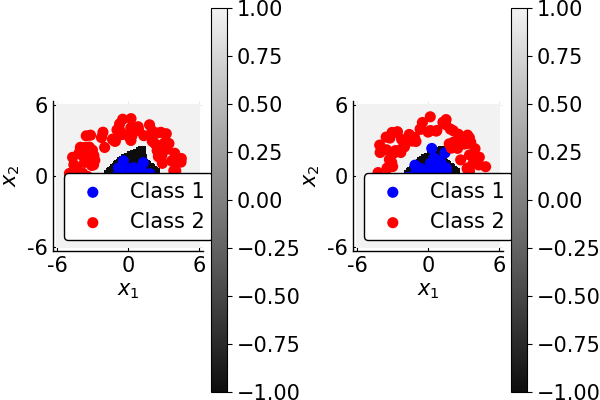

In [10]:
p1 = display_decision_boundaries(Xtrain, Ytrain, model)
p2 = display_decision_boundaries(Xvalid, Yvalid, model)
plot(p1, p2)

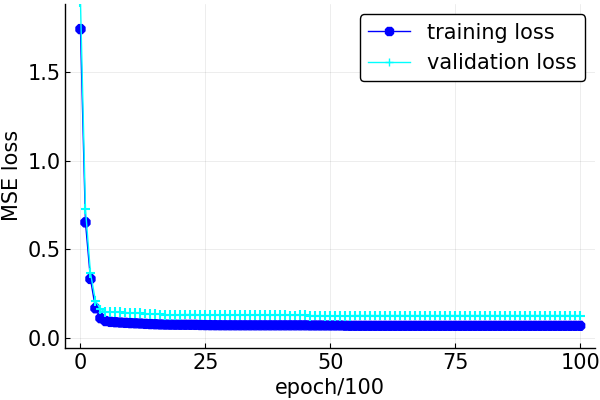

In [11]:
plot(xlabel="epoch/100", ylabel="MSE loss", ylim=[0,1.05*maximum(losstrain)])
plot!(0:nouter, losstrain, label="training loss", marker=:o, color=[:blue])
plot!(0:nouter, lossvalid, label="validation loss", marker=:+, color=[:cyan])
#savefig("ml-flux-loss.pdf")

In [14]:
x1range=LinRange(-1,1,31)*6
x2range=LinRange(-1,1,33)*6
layer2data = [layer2([x1;x2])[n].data for x1 = x1range, x2 = x2range, n=1:nhidden]
@show typeof(layer2data)
@show loss(Xtrain,Ytrain).data

typeof(layer2data) = Array{Float64,3}
(loss(Xtrain, Ytrain)).data = 0.06831558663699847


0.06831558663699847

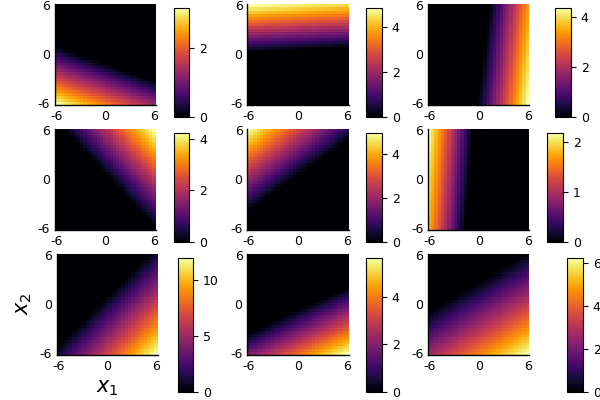

In [15]:
pl = []
fnt = font("DejaVu Sans", 9)
for n=1:nhidden
    tmp = heatmap(x1range, x2range, layer2data[:,:,n], transpose=true, aspect_ratio=1)
    plot!(tmp, xtick=-6:6:6, ytick=-6:6:6)
    plot!(tmp, xtickfont=fnt, ytickfont=fnt, legendfont=fnt)
    if n==7
        plot!(xlabel=L"x_1", ylabel=L"x_2")
    end
    push!(pl, tmp)
end
plot(pl[1:9]...)
#savefig("ml-flux-layer2.pdf")